In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Organize location and labels for relevant images

In [2]:
import pydicom
import torch
from torchvision import transforms, models
from tqdm import tqdm
import time
from matplotlib import pyplot as plt

In [3]:
def dcmtag2table(folder, list_of_tags):
    """
    Create a Pandas DataFrame with the <list_of_tags> DICOM tags
    from the DICOM files in <folder>
    
    Parameters:
        folder (str): path for the folder to be recursively walked through looking for DICOM files
        list_of_tags (list of strings): a list of DICOM tags with no whitespaces
        
    Returns:
        df (DataFrame): table of DICOM tags from the files in <folder>
    """
    
    list_of_tags = list_of_tags.copy()
    items = []
    table = []
    filelist = []
    print("Listing files...")
    start = time.time()
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            filelist.append(os.path.join(root,name)) #Get list of files that are present in the folder
    
    print("Time: " + str(time.time() - start))
    print("Reading files...")
    time.sleep(2)
    for _f in tqdm(filelist):
        try:
            ds = pydicom.dcmread(_f, stop_before_pixels=True) #Try to read each of the files, if they aren't pydicom compatible, run <except>
            items = [] # ^ The "stop_before_pixels" prevents the loading of the raw data, just metadata
            items.append(_f)

            for _tag in list_of_tags:
                if _tag in ds:
                    items.append(ds.data_element(_tag).value) #Gets the values for the paremeters defined in <list_of_tags>
                else:
                    items.append("Not found")

            table.append((items)) #make a table of the tag values
        except:
            print("Skipping non-DICOM: " + _f)

    
    list_of_tags.insert(0, "Filename") #add "Filename" to <list_of_tags>
    test = list(map(list, zip(*table)))
    dictone = {}

    for i, _tag in enumerate (list_of_tags):
        dictone[_tag] = test[i]

    df = pd.DataFrame(dictone)
    time.sleep(2)
    print("Finished.")
    return df
    

In [4]:
tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID']
dicom_tags_train =  dcmtag2table('../input/unifesp-x-ray-body-part-classifier/train', tags)

Listing files...
Time: 11.372487306594849
Reading files...


100%|██████████| 1738/1738 [00:28<00:00, 60.58it/s]


Finished.


In [5]:
# Add Target values to dicom_tags_train
# train = dicom_tags_train.merge(train_df, on = 'SOPInstanceUID')
# train.head(5)

In [6]:
# # See Rescale Intercept and Slope for Monochrome2 data
# pydicom.dcmread(list(dicom_tags_train.Filename[dicom_tags_train.PhotometricInterpretation == "MONOCHROME2"])[5], stop_before_pixels=True)
# #pydicom.dcmread(dicom_tags_train.Filename[0], stop_before_pixels=True)

In [7]:
# bodyparts = {
# 0 :'Abdomen',
# 1 :'Ankle',
# 2 :'Cervical Spine',
# 3 :'Chest',
# 4 :'Clavicles',
# 5 :'Elbow',
# 6 :'Feet',
# 7 :'Finger',
# 8 :'Forearm',
# 9 :'Hand',
# 10 :'Hip',
# 11 :'Knee',
# 12 :'Lower Leg',
# 13 :'Lumbar Spine',
# 14 :'Others',
# 15 :'Pelvis',
# 16 :'Shoulder',
# 17 :'Sinus',
# 18 :'Skull',
# 19 :'Thigh' ,
# 20 :'Thoracic Spine',
# 21 :'Wrist',
# }

# reverse_train_labels = dict((v,k) for k,v in bodyparts.items())

# def fill_targets(row):
#     row.Target = np.array(row.Target.split(" "))
#     for num in row.Target:
#         if num != '':
#             name = bodyparts[int(num)]
#             row.loc[name]=1
#     return row

# for key in bodyparts.keys():
#     train_df[bodyparts[key]] = 0

# train_labels = train_df.apply(fill_targets, axis=1)
# train_labels.head()

In [8]:
# train = dicom_tags_train.merge(train_labels, on = 'SOPInstanceUID')
# train.head()

In [9]:
def fill_targets(row):
    bodyparts = {
        0 :'Abdomen',
        1 :'Ankle',
        2 :'Cervical Spine',
        3 :'Chest',
        4 :'Clavicles',
        5 :'Elbow',
        6 :'Feet',
        7 :'Finger',
        8 :'Forearm',
        9 :'Hand',
        10 :'Hip',
        11 :'Knee',
        12 :'Lower Leg',
        13 :'Lumbar Spine',
        14 :'Others',
        15 :'Pelvis',
        16 :'Shoulder',
        17 :'Sinus',
        18 :'Skull',
        19 :'Thigh' ,
        20 :'Thoracic Spine',
        21 :'Wrist',
    }
    
    row.Target = np.array(row.Target.split(" "))
    for num in row.Target:
        if num != '':
            name = bodyparts[int(num)]
            row.loc[name]=1
    return row


def image_prep(in_dir, lab_f=False):
    """
    Function to prepare the pandas table for use in the DataLoader
    
    inputs:
        in_dir [path]: location of the input directory containing your data
        lab_f [path]: location of the csv containing the training labels, set as False if using with testing data
        
    output:
        img_tab [DataFrame]: Relevant information about the dataset being used
    """
    
    # Key for labels
    bodyparts = {
        0 :'Abdomen',
        1 :'Ankle',
        2 :'Cervical Spine',
        3 :'Chest',
        4 :'Clavicles',
        5 :'Elbow',
        6 :'Feet',
        7 :'Finger',
        8 :'Forearm',
        9 :'Hand',
        10 :'Hip',
        11 :'Knee',
        12 :'Lower Leg',
        13 :'Lumbar Spine',
        14 :'Others',
        15 :'Pelvis',
        16 :'Shoulder',
        17 :'Sinus',
        18 :'Skull',
        19 :'Thigh' ,
        20 :'Thoracic Spine',
        21 :'Wrist',
    }

    reverse_train_labels = dict((v,k) for k,v in bodyparts.items())
    
    # Relevant tags for inclusion in returned dataframe:
    tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID']

    dicom_tags =  dcmtag2table(in_dir, tags)
    
    # Load in the training labels if present:
    if lab_f:
        lab_df = pd.read_csv(lab_f)
        for key in bodyparts.keys():
            lab_df[bodyparts[key]] = 0
            
        dicom_labels = lab_df.apply(fill_targets, axis=1)

        img_df = dicom_tags.merge(dicom_labels, on = 'SOPInstanceUID')
    else:
        img_df = dicom_tags
    
    return img_df

# Create Dataset and DataLoader

In [10]:
class img_dataset(torch.utils.data.Dataset): #torch....Dataset characterizes a dataset for Pytorch
    def __init__(self, in_dir, lab_f):
        # Make function incorporating dcmtag2table and the steps required to organize data
        self.data = image_prep(in_dir, lab_f)
        
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.234,0.225]),
        ])
            
    def __len__(self):
        return len(self.data.Filename)
    
    
    def __getitem__(self, idx):
        # 'Generates one sample of data'
        
        # This is where I get a filename and load it using: self.data.Filename[idx]
        # Look at: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        f_path = self.data.Filename.iloc[idx]
        
        dcm = pydicom.dcmread(f_path)
        img = dcm.pixel_array
        
        # randomize whether it is using Monochrome1 or Monochrome2
        if np.random.choice([0,1]):
            img = np.invert(img)
        
        # TODO: Add some sort of normalization step aside from this?
        img = img/img.max()
        
        img = torch.from_numpy(img)
        #print(img.repeat(3,1,1).size())
        X = self.preprocess(img.repeat(3,1,1))
        # For some reason, ResNet only takes doubles
        X = X.double()
        
        # Get the label information
        Y = torch.tensor(self.data.iloc[idx,5:])
        Y = Y.double()
        
        # returns <input> and <target>, so the image and the vector of classification
        
        return X, Y
    

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    img_dataset('../input/unifesp-x-ray-body-part-classifier/train','../input/unifesp-x-ray-body-part-classifier/train.csv'),
    batch_size = 64,
    shuffle = True
)

Listing files...
Time: 1.882129192352295
Reading files...


100%|██████████| 1738/1738 [00:03<00:00, 457.59it/s]


Finished.


# Explore Images

In [12]:
source = img_dataset('../input/unifesp-x-ray-body-part-classifier/train','../input/unifesp-x-ray-body-part-classifier/train.csv')

Listing files...
Time: 1.9386897087097168
Reading files...


100%|██████████| 1738/1738 [00:03<00:00, 479.49it/s]


Finished.


In [13]:
for i in range(4):
    X,Y = source.__getitem__(i)
    print(X.size())

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [14]:
X.unsqueeze(0)

tensor([[[[ 1.1813,  1.1307,  1.2079,  ...,  1.8990,  1.9558,  1.9677],
          [ 1.1365,  1.1078,  1.2453,  ...,  1.9069,  1.9606,  1.9929],
          [ 1.1559,  1.1729,  1.1921,  ...,  1.9481,  1.9992,  1.9689],
          ...,
          [ 0.0611, -0.0029, -0.1101,  ...,  1.6530,  1.7187,  1.7168],
          [-0.0401, -0.0672, -0.1119,  ...,  1.6994,  1.7449,  1.6089],
          [-0.0872, -0.1138, -0.0524,  ...,  1.6790,  1.7630,  1.7203]],

         [[ 1.2800,  1.2304,  1.3060,  ...,  1.9823,  2.0380,  2.0496],
          [ 1.2361,  1.2081,  1.3426,  ...,  1.9901,  2.0426,  2.0742],
          [ 1.2551,  1.2718,  1.2906,  ...,  2.0304,  2.0805,  2.0507],
          ...,
          [ 0.1837,  0.1210,  0.0162,  ...,  1.7416,  1.8059,  1.8040],
          [ 0.0847,  0.0582,  0.0144,  ...,  1.7870,  1.8315,  1.6985],
          [ 0.0386,  0.0126,  0.0727,  ...,  1.7670,  1.8492,  1.8075]],

         [[ 1.5534,  1.5019,  1.5804,  ...,  2.2838,  2.3417,  2.3538],
          [ 1.5078,  1.4786,  

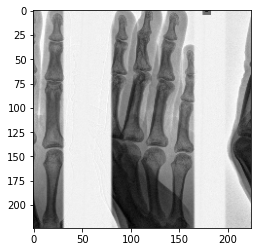

In [15]:
plt.imshow(X[2,:,:], cmap = 'gray')
plt.show()

# Define the model
Try a few different network models in order to figure out what works best

In [16]:
class Model_v1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the different layers
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=22)
        )
        self.base_model = resnet
        self.sigm = torch.nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass information
        return self.sigm(self.base_model(x))

# For some reason I need to set the weights of ResNet to double, even though they are originally float32
model = Model_v1().double()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [17]:
# for i in model.parameters():
#     print(i.dtype)

In [18]:
# image, label = [ x[0] for x in iter(train_dataloader).next() ]
# image.double().dtype

# Define the optimizer

In [19]:
criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Performance metrics

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

# Train the Network

In [21]:
epoch = 0
max_epoch_number = 5
iteration = 0
test_freq = 5 #how often to print status reports

while True:
    batch_losses = []
    for imgs, targets in tqdm(train_dataloader):
        #imgs, targets = imgs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        model_result = model(imgs)
        loss = criterion(model_result, targets)#.type(torch.float))
        
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss_value)
        
#         if iteration % test_freq == 0:
#             model.eval()
#             with torch.no_grad():
#                 model_result = []
#                 targets = []
#                 for imgs, batch_targets in test_dataloader:
#                     imgs = imgs.to(device)
#                     model_batch_result = model(imgs)
#                     model_result.extend(model_batch_result.cpu().numpy())
#                     targets.extend(batch_targets.cpu().numpy())

#             result = calculate_metrics(np.array(model_result), np.array(targets))
#             print("epoch:{:2d} iter:{:3d} test: "
#                   "micro f1: {:.3f} "
#                   "macro f1: {:.3f} "
#                   "samples f1: {:.3f}".format(epoch, iteration,
#                                               result['micro/f1'],
#                                               result['macro/f1'],
#                                               result['samples/f1']))

#             model.train()
#         iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
#     if epoch % save_freq == 0:
#         checkpoint_save(model, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|          | 0/28 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
 86%|████████▌ | 24/28 [1:38:08<15:44, 236.16s/it]/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bi

epoch: 0 iter:  0 train: loss:0.112


100%|██████████| 28/28 [1:47:39<00:00, 230.70s/it]


epoch: 1 iter:  0 train: loss:0.055


100%|██████████| 28/28 [1:48:07<00:00, 231.70s/it]


epoch: 2 iter:  0 train: loss:0.041


100%|██████████| 28/28 [1:48:01<00:00, 231.49s/it]


epoch: 3 iter:  0 train: loss:0.035


100%|██████████| 28/28 [1:46:24<00:00, 228.03s/it]


epoch: 4 iter:  0 train: loss:0.031


100%|██████████| 28/28 [1:46:44<00:00, 228.74s/it]

epoch: 5 iter:  0 train: loss:0.031


# Test the Network